In [15]:
import numpy as np
import control
from control.matlab import *
import matplotlib.pyplot as plt

In [41]:
num = [1]
den = [1, 3, 2]
s = tf('s')
G = tf(num,den)
tau = stepinfo(G)['SettlingTime']/5
G_proper = G * (1 + 5e-1 * (tau / (2 * np.pi)) * s) **2

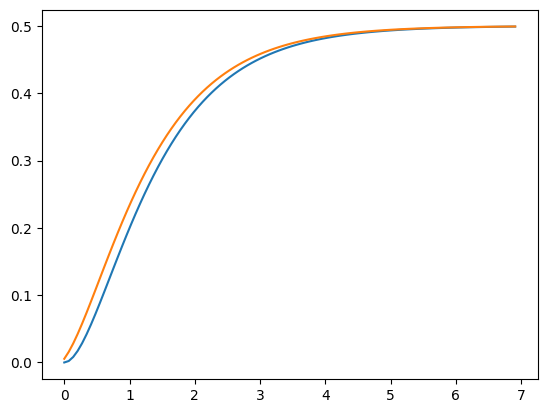

In [42]:
plt.plot(step(G)[1], step(G)[0])
plt.plot(step(G_proper)[1], step(G_proper)[0])

In [43]:
G_proper

TransferFunction(array([0.00547885, 0.14803848, 1.        ]), array([1, 3, 2]))

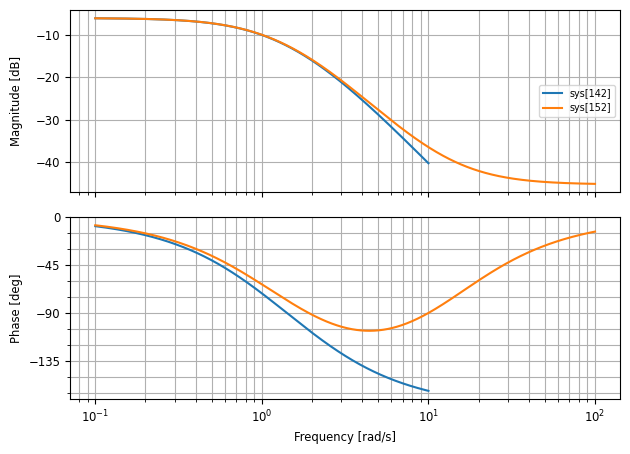

In [44]:
bode(G)
bode(G_proper)
plt.show()

In [45]:
from utils import prbs, random_signal
ts = 1e-2
T = 20
t = np.arange(0, T, ts)
y_ideal = prbs(len(t))
#u = np.random.normal(0, 10, t.shape)
u = lsim(G_proper**(-1), y_ideal, t)[0]

/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1003: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


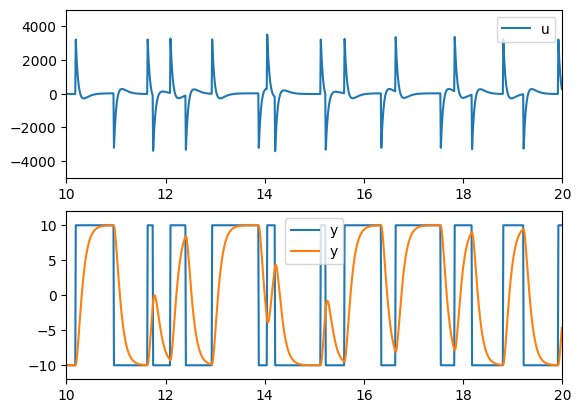

In [46]:
y, t, _ = lsim(G, u, t)
plt.subplot(211)
plt.plot(t, u, label="u")
plt.xlim([10, 20])
plt.ylim([-5000,5000])
plt.legend()

plt.subplot(212)
plt.plot(t, y_ideal, label="y")
plt.plot(t, y, label="y")
plt.xlim([10, 20])
plt.ylim([-12,12])
plt.legend()

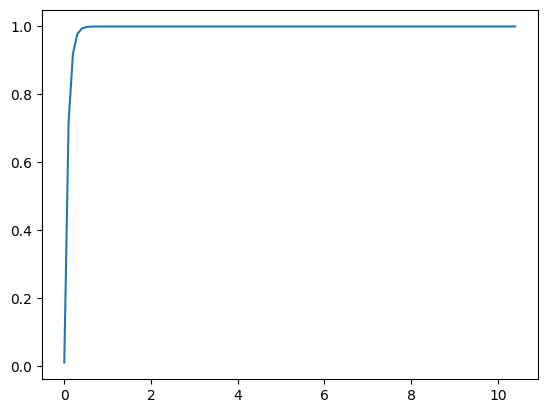

In [71]:
# VRFT
s = tf('s')
tau = 0.5 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = M*(1 + 1e-2*(tau/(2*np.pi))*s) # add a high freq zero for inversion
T_cl = tau + 10#0.5
t_cl = np.arange(0, T_cl, ts)
y_d, _ = step(M, t_cl)
plt.plot(t_cl, y_d)

In [72]:
# vrft
r_v = lsim(M**(-1), y, t)[0]
e_v = r_v - y

In [73]:
B=[tf([1],[1],ts),
   tf(ts*np.array([1, 1]),2*np.array([1, -1]),ts)]

In [74]:
import cvxpy as cp
theta = cp.Variable(2)
u_theta = theta[0]*lsim(B[0], e_v, t)[0] + theta[1]*lsim(B[1], e_v, t)[0]

In [75]:
cost = cp.sum_squares(u - u_theta)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()
theta_sol = theta.value

In [76]:
C = theta_sol[0]*B[0] + theta_sol[1]*B[1]

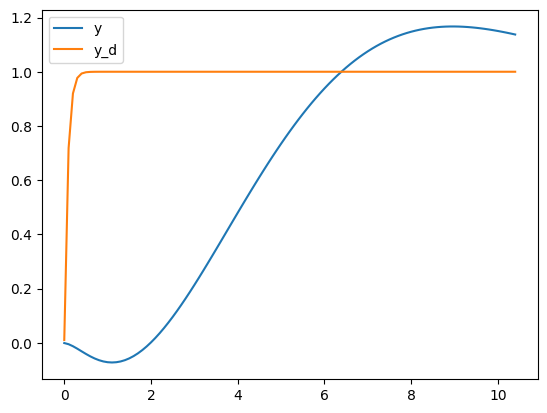

In [77]:
G = c2d(G, ts, 'tustin')
F = C*G/(1 + C*G)
y_cl, _ = step(F, t_cl)
plt.plot(t_cl, y_cl, label='y')
plt.plot(t_cl, y_d, label='y_d')
plt.legend()
plt.show()